## Model Implementation
The following code is responsible for constructing the BSL Sign Language Recognition Model. It is intended for model implementation purposes and should NOT be executed for testing, as doing so may disrupt the entire model implementation process.

## Step 1: Install dependencies  
- pip install opencv-python  
- pip install mediapipe 
- pip install tensorflow 
- pip install scikit-learn

## Step 2: Import All The Depencies

In [1]:
import cv2
import mediapipe as mp
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from IPython.display import Image, display
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout, GRU
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.activations import elu
import tensorflow as tf

## Step 3: Detect Face, Hand and Pose Landmark Using MediaPipe Holistic
The code below is using MediaPipe Holistic Pipeline to detect hand, pose and facial landmarks. The landmarks are drawn with specific colors and styles.

In [2]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                   
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [4]:
def draw_landmarks(image, results):
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                                 mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                                 mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                                 ) 
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                 mp_drawing.DrawingSpec(color=(0, 128, 0), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(128, 0, 128), thickness=2, circle_radius=2)
                                 ) 
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(0, 0, 128), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 ) 
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                                 mp_drawing.DrawingSpec(color=(0, 0, 128), thickness=2, circle_radius=4), 
                                 mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                                 ) 

In [ ]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic (
    min_detection_confidence=0.5, 
    min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            print('Ignoring Empty Camera Frame')
            continue

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        draw_landmarks(image, results)
        # Show to screen
        cv2.imshow('MediaPipe Holistic Example Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

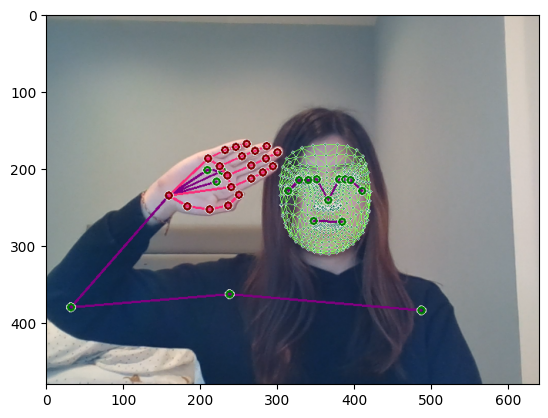

In [10]:
# Draw the result out
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

### Reference
https://www.geeksforgeeks.org/python-facial-and-hand-recognition-using-mediapipe-holistic/

## Step 2: Extract Keypoints

The function extract_keypoints first checks if landmarks are detected for pose, face, left hand, and right hand. For each component where landmarks are detected, it creates numpy arrays storing the (x, y, z) coordinates and visibility information for each landmark. These arrays are then flattened to make them one-dimensional and concatenated together into a single numpy array. If no landmarks are detected for a specific component, the function generates zero-filled arrays as placeholders. Ultimately, the function returns this concatenated array, which represents all the detected keypoints from the input results.

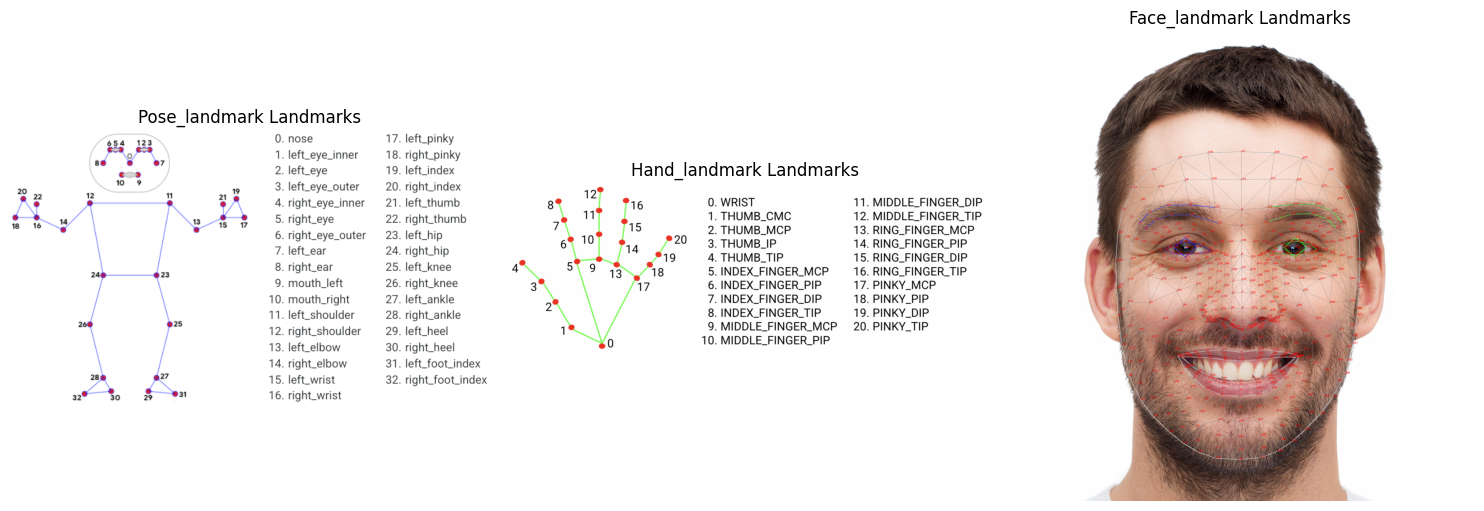

In [5]:
image_paths = ['img/pose_landmark.png', 'img/hand_landmark.png', 'img/face_landmark.png']

fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

for ax, path in zip(axes, image_paths):
    image = mpimg.imread(path)
    ax.imshow(image)
    ax.set_title(path.split('/')[-1].split('.')[0].capitalize() + ' Landmarks')
    ax.axis('off')

plt.tight_layout()
plt.show()


In [5]:
def extract_keypoints(results):
    if results.pose_landmarks:
        pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
    else: 
        pose = np.zeros(33*4)

    if results.face_landmarks: 
        face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten()
    else: 
        face = np.zeros(468*3)

    if results.left_hand_landmarks: 
        lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten()
    else: 
        lh = np.zeros(21*3)

    if results.right_hand_landmarks:  
        rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten()
    else:  
        rh = np.zeros(21*3)

    return np.concatenate([pose, face, lh, rh])

In [11]:
# Print the table of keypoints, an example how the result from the extract_keypoints() function will look like.
def keypoints_to_dataframe(keypoints):
    columns = ['X', 'Y', 'Z', 'Visibility']

    pose_keypoints = 33
    face_keypoints = 468
    hand_keypoints = 21

    keypoint_sets = [
        (pose_keypoints, 'Pose'),
        (face_keypoints, 'Face'),
        (hand_keypoints, 'Left Hand'),
        (hand_keypoints, 'Right Hand')
    ]

    extracted_keypoints = []

    for num_keypoints, category in keypoint_sets:
        start_index = sum(kp * 3 for kp, _ in keypoint_sets[:keypoint_sets.index((num_keypoints, category))])
        end_index = start_index + num_keypoints * 3
        keypoints_subset = keypoints[start_index:end_index]
        keypoints_subset = [keypoints_subset[i:i+3] for i in range(0, len(keypoints_subset), 3)]
        extracted_keypoints.extend([(category, *kp) for kp in keypoints_subset])

    df = pd.DataFrame(extracted_keypoints, columns=['Category', 'X', 'Y', 'Z'])

    return df

keypoints = extract_keypoints(results)

keypoints_df = keypoints_to_dataframe(keypoints)
pd.set_option('display.max_rows', None)

table_styles = [
    dict(selector='th', props=[('text-align', 'center')]),  
    dict(selector='td', props=[('text-align', 'center')])  
]

keypoints_df_styled = keypoints_df.style.set_table_styles(table_styles)
keypoints_df_styled

,Category,X,Y,Z
0,Pose,0.444052,0.528978,-0.804130
1,Pose,0.999961,0.457878,0.477320
2,Pose,-0.725851,0.999916,0.472566
3,Pose,0.474028,-0.725614,0.999942
4,Pose,0.483922,0.471399,-0.725360
5,Pose,0.999921,0.411800,0.490053
6,Pose,-0.746105,0.999885,0.396373
7,Pose,0.495304,-0.745699,0.999907
8,Pose,0.381275,0.501423,-0.745939
9,Pose,0.999844,0.501124,0.495895


## Step 3: Define the Actions To Be Recorded

In [6]:
greeting_actions = ['Hello', 'Goodbye', 'Please', 'Sorry', 'Welcome']
basic_actions = ['Maybe', 'Family', 'Should', 'Yes', 'Sure']
question_actions = ['Ask','Why', 'What', 'When', 'How']

actions = greeting_actions + basic_actions + question_actions

## Step 4: Create Directory For Each Action
This code create directories to organise each action in the dataset. Each action has its own subdirectory containing 30 video directories, and each video directory containing 30 frames.

In [7]:
DATA_PATH = 'BSL_Dataset'
num_videos = 30
num_frames = 30
for action in actions:
    for video in range(num_videos):
        try:
            os.makedirs(f"{DATA_PATH}/{action}/{video}")
        except FileExistsError:
            pass

## Step 5: Record Videos for Each Action and Extract the Keypoint Values

In [14]:
def add_starting_text(image, action, sequence):
    height, width, _ = image.shape
    text = 'INITIALIZING COLLECTION'
    font = cv2.FONT_HERSHEY_TRIPLEX
    font_scale = 1
    font_thickness = 4
    color = (50, 50, 50)
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = int((width - text_size[0]) / 2)
    text_y = 50
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, font_thickness, cv2.LINE_AA)
    cv2.imshow('OpenCV Feed', image)
    return image

def display_image(image, action, sequence):
    height, width, _ = image.shape
    text = f'Frames for \'{action}\' '
    font = cv2.FONT_HERSHEY_DUPLEX
    font_scale = 0.5
    font_thickness = 1
    color = (255, 255, 255)  
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = 15  
    text_y = 12 + text_size[1]  
    cv2.putText(image, text, (text_x, text_y), font, font_scale, color, font_thickness, cv2.LINE_AA)
    cv2.imshow('OpenCV Feed', image)

def save_keypoints(keypoints, action, video, frame_num, data_path=DATA_PATH):
    save_path = os.path.join(data_path, action, str(video))
    os.makedirs(save_path, exist_ok=True)
    npy_path = os.path.join(save_path, str(frame_num))
    np.save(npy_path, keypoints)

In [20]:
cap = cv2.VideoCapture(0)
with mp_holistic.Holistic (
    min_detection_confidence=0.5, 
    min_tracking_confidence=0.5) as holistic:
    for action in actions:
        for video in range(num_videos):
            for frame_num in range(num_frames):
                success, frame = cap.read()
                if not success:
                    print('Ignoring Empty Camera Frame')
                    continue
                image, results = mediapipe_detection(frame, holistic)
                draw_landmarks(image, results)
                if frame_num == 0: 
                    image = add_starting_text(image, action, video)
                    cv2.waitKey(1000)
                display_image(image, action, video)
                keypoints = extract_keypoints(results)
                save_keypoints(keypoints, action, video, frame_num)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

## Step 6: Preprocess Data For Training
First, the code assigns a unique numerical index to each action label. This step is important for organizing the data and training the model effectively later on. Then, it collects all the frames from each video and stores them in a structured array called 'video_data'. Preserving the order of frames in each video is critical for training the machine learning model. By maintaining the sequence of frames, the model can learn and capture the temporal dependencies, enhancing its capability to identify actions or gestures accurately.

In [8]:
action_index_map = {}
for num, action in enumerate(actions):
    action_index_map[action] = num

video_data, action_labels = [], []
for action in actions:
    for video_index in range(num_videos):
        video_frames = [np.load(os.path.join(DATA_PATH, action, str(video_index), f"{frame_num}.npy")) for frame_num in range(num_frames)]
        video_data.append(video_frames)
        action_labels.append(action_index_map[action])

In [10]:
# These are the frames from each video which will be used for the training process later.
print(np.array(video_data))

[[[ 0.51846194  0.52573562 -1.07002664 ...  0.35985658  0.39516914
   -0.01910108]
  [ 0.51074988  0.52544916 -0.95609504 ...  0.35878557  0.39300829
   -0.01819813]
  [ 0.50562274  0.52569371 -1.04953396 ...  0.35884005  0.39406198
   -0.01746652]
  ...
  [ 0.55512017  0.54839444 -0.83857757 ...  0.          0.
    0.        ]
  [ 0.55153167  0.54694533 -0.88583434 ...  0.          0.
    0.        ]
  [ 0.54839021  0.54252869 -0.8777048  ...  0.          0.
    0.        ]]

 [[ 0.54355806  0.54194134 -0.88089371 ...  0.          0.
    0.        ]
  [ 0.53435028  0.5432747  -0.85855925 ...  0.          0.
    0.        ]
  [ 0.53250426  0.54321408 -0.82143784 ...  0.          0.
    0.        ]
  ...
  [ 0.53132594  0.53657931 -0.84373271 ...  0.329052    0.3421849
   -0.02280252]
  [ 0.53108066  0.53714842 -0.84302938 ...  0.32848847  0.34202889
   -0.02259179]
  [ 0.53103417  0.53741831 -0.8397854  ...  0.32693997  0.34328803
   -0.02390956]]

 [[ 0.53078902  0.53753364 -0.8397270

In [32]:
# The numerical label for each videos, the data will be fed for machine learning training
print('Each videos has its own index:')
print(action_index_map)
print('\nAfter data preprocessing, each action label is replaced with the index label.')
print(labels)

Each videos has its own index:
{'Hello': 0, 'Goodbye': 1, 'Please': 2, 'Sorry': 3, 'Welcome': 4, 'Maybe': 5, 'Family': 6, 'Should': 7, 'Yes': 8, 'Sure': 9, 'Ask': 10, 'Why': 11, 'What': 12, 'When': 13, 'How': 14}

After data preprocessing, each action label is replaced with the index label.
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

## Step 7: Split the Dataset To Training and Test Set
The numerical label is converted into one-hot encoded vectors for the training process later. 80% of data is used for training and the remaining 20% is used for testing.

In [9]:
X = np.array(video_data)
y = to_categorical(action_labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Step 8: Data Augmentatation

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2),
    tf.keras.layers.RandomBrightness(factor=0.2)
])

def augment_frame(frame):
    frame = tf.expand_dims(frame, axis=0)  
    augmented_frame = data_augmentation(tf.expand_dims(frame, axis=0), training=True)
    return augmented_frame[0][0] 

X_train = np.array(X_train)
augmented_X_train = []
for video_frames in X_train:
    augmented_video_frames = [augment_frame(frame) for frame in video_frames]
    augmented_X_train.append(augmented_video_frames)

X_train_augmented = np.array(augmented_X_train)

## Step 9:Train the Data Using RNN

Create a log file and callback will be used during model training to log various metrics and information, which can be later visualized using TensorBoard.

In [11]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

### Model 1: Train Using SimpleRNN Network

In [15]:
# Sequential API allows us to create model layer by layer
model = Sequential()
model.add(SimpleRNN(64, return_sequences=True, activation='relu', input_shape=(30, 1662))) # 30*1662 is the total number of neurons in the input layer
model.add(SimpleRNN(128, return_sequences=True,  activation='relu'))
model.add(SimpleRNN(64,  activation='relu'))
model.add(Dense(len(actions), activation='softmax'))  

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[tb_callback])


Epoch 1/150
12/12 [==============================] - 8s 161ms/step - loss: 2.7438 - accuracy: 0.0778 - val_loss: 2.6096 - val_accuracy: 0.0556
Epoch 2/150
12/12 [==============================] - 1s 56ms/step - loss: 2.5151 - accuracy: 0.1083 - val_loss: 2.3982 - val_accuracy: 0.2111
Epoch 3/150
12/12 [==============================] - 1s 58ms/step - loss: 2.2861 - accuracy: 0.1667 - val_loss: 2.2497 - val_accuracy: 0.1111
Epoch 4/150
12/12 [==============================] - 1s 57ms/step - loss: 2.1867 - accuracy: 0.1944 - val_loss: 2.1177 - val_accuracy: 0.2556
Epoch 5/150
12/12 [==============================] - 1s 58ms/step - loss: 2.0634 - accuracy: 0.2306 - val_loss: 1.9716 - val_accuracy: 0.3000
Epoch 6/150
12/12 [==============================] - 1s 57ms/step - loss: 2.0323 - accuracy: 0.2306 - val_loss: 1.9148 - val_accuracy: 0.2000
Epoch 7/150
12/12 [==============================] - 1s 58ms/step - loss: 1.9063 - accuracy: 0.2500 - val_loss: 1.8610 - val_accuracy: 0.2444
Epoch

12/12 [==============================] - 1s 60ms/step - loss: 0.3973 - accuracy: 0.8500 - val_loss: 1.3765 - val_accuracy: 0.5889
Epoch 116/150
12/12 [==============================] - 1s 60ms/step - loss: 0.8345 - accuracy: 0.7528 - val_loss: 0.6502 - val_accuracy: 0.7778
Epoch 117/150
12/12 [==============================] - 1s 58ms/step - loss: 0.7368 - accuracy: 0.7250 - val_loss: 0.5651 - val_accuracy: 0.7889
Epoch 118/150
12/12 [==============================] - 1s 57ms/step - loss: 0.4170 - accuracy: 0.8917 - val_loss: 0.3133 - val_accuracy: 0.9444
Epoch 119/150
12/12 [==============================] - 1s 57ms/step - loss: 0.2182 - accuracy: 0.9556 - val_loss: 0.1906 - val_accuracy: 0.9667
Epoch 120/150
12/12 [==============================] - 1s 57ms/step - loss: 0.1728 - accuracy: 0.9528 - val_loss: 0.2612 - val_accuracy: 0.9556
Epoch 121/150
12/12 [==============================] - 1s 57ms/step - loss: 0.1629 - accuracy: 0.9500 - val_loss: 0.2071 - val_accuracy: 0.9556
Epoch 

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 30, 64)            110528    
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 30, 128)           24704     
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 64)                12352     
                                                                 
 dense_3 (Dense)             (None, 15)                975       
                                                                 
Total params: 148559 (580.31 KB)
Trainable params: 148559 (580.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
model.save('simplernn.keras')

### Method 2: Train the Model Using LSTM

In [52]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), callbacks=[tb_callback])

Epoch 1/150
12/12 [==============================] - 17s 708ms/step - loss: 3.9915 - categorical_accuracy: 0.0472 - val_loss: 2.7746 - val_categorical_accuracy: 0.1000
Epoch 2/150
12/12 [==============================] - 7s 588ms/step - loss: 2.7554 - categorical_accuracy: 0.0972 - val_loss: 3.4901 - val_categorical_accuracy: 0.0000e+00
Epoch 3/150
12/12 [==============================] - 7s 597ms/step - loss: 2.6975 - categorical_accuracy: 0.0639 - val_loss: 2.5827 - val_categorical_accuracy: 0.0556
Epoch 4/150
12/12 [==============================] - 7s 587ms/step - loss: 2.4836 - categorical_accuracy: 0.0611 - val_loss: 2.5593 - val_categorical_accuracy: 0.1222
Epoch 5/150
12/12 [==============================] - 7s 593ms/step - loss: 2.6110 - categorical_accuracy: 0.1222 - val_loss: 2.7084 - val_categorical_accuracy: 0.0333
Epoch 6/150
12/12 [==============================] - 7s 594ms/step - loss: 2.7069 - categorical_accuracy: 0.0750 - val_loss: 2.7101 - val_categorical_accuracy: 

Epoch 50/150
12/12 [==============================] - 7s 606ms/step - loss: 1.8790 - categorical_accuracy: 0.2889 - val_loss: 2.1334 - val_categorical_accuracy: 0.2222
Epoch 51/150
12/12 [==============================] - 7s 608ms/step - loss: 1.8644 - categorical_accuracy: 0.3139 - val_loss: 1.9900 - val_categorical_accuracy: 0.3000
Epoch 52/150
12/12 [==============================] - 7s 601ms/step - loss: 1.8301 - categorical_accuracy: 0.3611 - val_loss: 2.1667 - val_categorical_accuracy: 0.1556
Epoch 53/150
12/12 [==============================] - 7s 608ms/step - loss: 2.0789 - categorical_accuracy: 0.2417 - val_loss: 2.0481 - val_categorical_accuracy: 0.1778
Epoch 54/150
12/12 [==============================] - 7s 604ms/step - loss: 1.8458 - categorical_accuracy: 0.3306 - val_loss: 1.9354 - val_categorical_accuracy: 0.3000
Epoch 55/150
12/12 [==============================] - 7s 608ms/step - loss: 1.6953 - categorical_accuracy: 0.3750 - val_loss: 1.8222 - val_categorical_accuracy:

Epoch 99/150
12/12 [==============================] - 7s 594ms/step - loss: 1.1817 - categorical_accuracy: 0.5139 - val_loss: 1.5480 - val_categorical_accuracy: 0.3667
Epoch 100/150
12/12 [==============================] - 7s 600ms/step - loss: 1.4413 - categorical_accuracy: 0.4556 - val_loss: 1.3825 - val_categorical_accuracy: 0.3778
Epoch 101/150
12/12 [==============================] - 7s 593ms/step - loss: 1.1493 - categorical_accuracy: 0.5056 - val_loss: 1.3905 - val_categorical_accuracy: 0.3556
Epoch 102/150
12/12 [==============================] - 7s 594ms/step - loss: 1.0347 - categorical_accuracy: 0.5528 - val_loss: 1.3352 - val_categorical_accuracy: 0.4111
Epoch 103/150
12/12 [==============================] - 7s 597ms/step - loss: 0.9807 - categorical_accuracy: 0.6083 - val_loss: 1.2280 - val_categorical_accuracy: 0.5222
Epoch 104/150
12/12 [==============================] - 7s 590ms/step - loss: 0.9588 - categorical_accuracy: 0.6361 - val_loss: 1.4336 - val_categorical_accu

In [53]:
model.save('lstmmodel.keras')

In [54]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_117 (LSTM)             (None, 30, 64)            442112    
                                                                 
 lstm_118 (LSTM)             (None, 30, 128)           98816     
                                                                 
 lstm_119 (LSTM)             (None, 64)                49408     
                                                                 
 dense_117 (Dense)           (None, 64)                4160      
                                                                 
 dense_118 (Dense)           (None, 32)                2080      
                                                                 
 dense_119 (Dense)           (None, 15)                495       
                                                                 
Total params: 597071 (2.28 MB)
Trainable params: 5970

### Method 3: Train the Model Using GRU

In [22]:
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(30, 1662)))
model.add(Dropout(0.2))  
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))  
model.add(GRU(64))
model.add(Dropout(0.2))  
model.add(Dense(len(actions), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[tb_callback])

Epoch 1/50
12/12 [==============================] - 10s 209ms/step - loss: 2.7537 - accuracy: 0.0778 - val_loss: 2.6801 - val_accuracy: 0.1444
Epoch 2/50
12/12 [==============================] - 1s 92ms/step - loss: 2.4526 - accuracy: 0.1806 - val_loss: 2.3097 - val_accuracy: 0.2444
Epoch 3/50
12/12 [==============================] - 1s 96ms/step - loss: 2.2087 - accuracy: 0.2139 - val_loss: 2.1913 - val_accuracy: 0.0889
Epoch 4/50
12/12 [==============================] - 1s 89ms/step - loss: 2.1019 - accuracy: 0.2306 - val_loss: 2.0881 - val_accuracy: 0.1889
Epoch 5/50
12/12 [==============================] - 1s 101ms/step - loss: 2.0022 - accuracy: 0.2806 - val_loss: 2.0553 - val_accuracy: 0.0778
Epoch 6/50
12/12 [==============================] - 1s 86ms/step - loss: 1.9295 - accuracy: 0.3028 - val_loss: 2.0591 - val_accuracy: 0.1667
Epoch 7/50
12/12 [==============================] - 1s 83ms/step - loss: 1.7415 - accuracy: 0.4083 - val_loss: 1.5947 - val_accuracy: 0.6222
Epoch 8/50

In [23]:
model.save('grubslmodel.keras')

In [24]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 30, 64)            331776    
                                                                 
 dropout_24 (Dropout)        (None, 30, 64)            0         
                                                                 
 gru_25 (GRU)                (None, 30, 128)           74496     
                                                                 
 dropout_25 (Dropout)        (None, 30, 128)           0         
                                                                 
 gru_26 (GRU)                (None, 64)                37248     
                                                                 
 dropout_26 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 15)               

## Step 10: Evaluation and Analysis
The code prints out the accuracy, precision, recall, and F1 score of the models, along with a classification report. Additionally, it displays a confusion matrix to provide insights into the model's misclassifications.

3/3 [==============================] - 1s 28ms/step


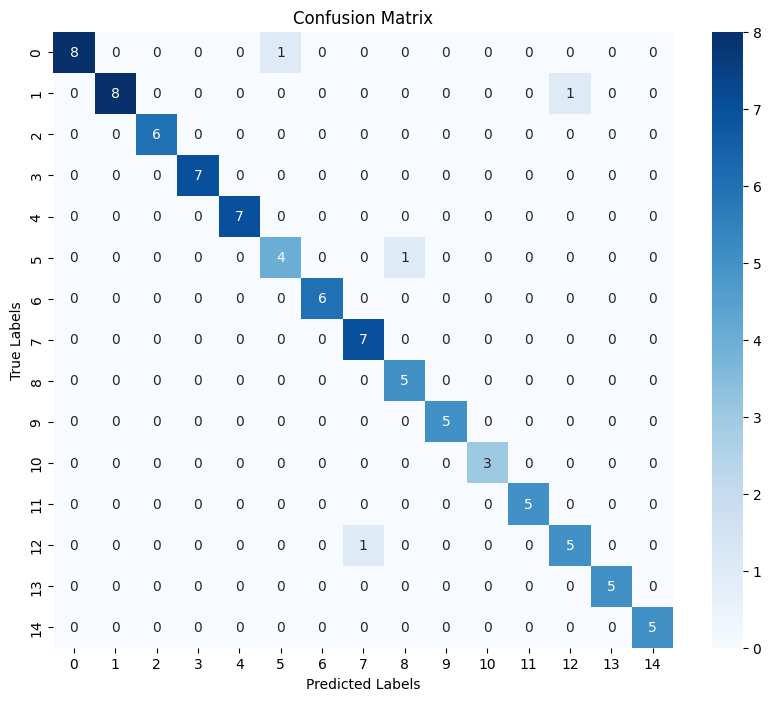

Accuracy: 0.9555555555555556
Precision: 0.9587962962962961
Recall: 0.9555555555555556
F1 Score: 0.9557773816597346
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       1.00      0.89      0.94         9
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       0.80      0.80      0.80         5
           6       1.00      1.00      1.00         6
           7       0.88      1.00      0.93         7
           8       0.83      1.00      0.91         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         5
          12       0.83      0.83      0.83         6
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5

    accuracy       

In [11]:
model = tf.keras.models.load_model('simplernn.keras')
y_hat = model.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()
multilabel_confusion_matrix(y_true, y_hat)

conf_mat = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_true, y_hat)
precision = precision_score(y_true, y_hat, average='weighted')
recall = recall_score(y_true, y_hat, average='weighted')
f1 = f1_score(y_true, y_hat, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

class_report = classification_report(y_true, y_hat)
print(class_report)

3/3 [==============================] - 1s 27ms/step


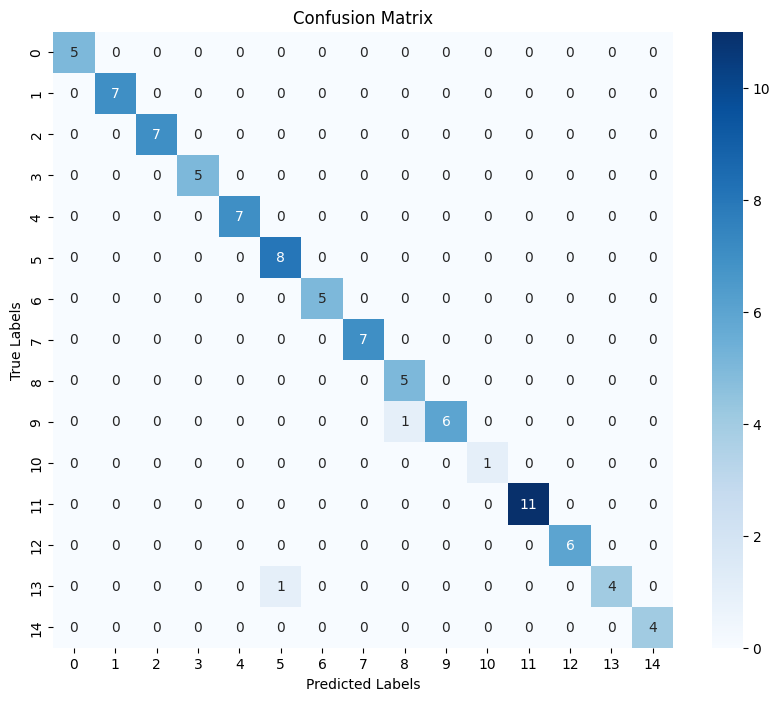

Accuracy: 0.9777777777777777
Precision: 0.9808641975308642
Recall: 0.9777777777777777
F1 Score: 0.9775649912904816
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         7
           5       0.89      1.00      0.94         8
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         7
           8       0.83      1.00      0.91         5
           9       1.00      0.86      0.92         7
          10       1.00      1.00      1.00         1
          11       1.00      1.00      1.00        11
          12       1.00      1.00      1.00         6
          13       1.00      0.80      0.89         5
          14       1.00      1.00      1.00         4

    accuracy       

In [27]:
model = tf.keras.models.load_model('grubslmodel.keras')
y_hat = model.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()
multilabel_confusion_matrix(y_true, y_hat)

conf_mat = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_true, y_hat)
precision = precision_score(y_true, y_hat, average='weighted')
recall = recall_score(y_true, y_hat, average='weighted')
f1 = f1_score(y_true, y_hat, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

from sklearn.metrics import classification_report
class_report = classification_report(y_true, y_hat)
print(class_report)

3/3 [==============================] - 4s 263ms/step


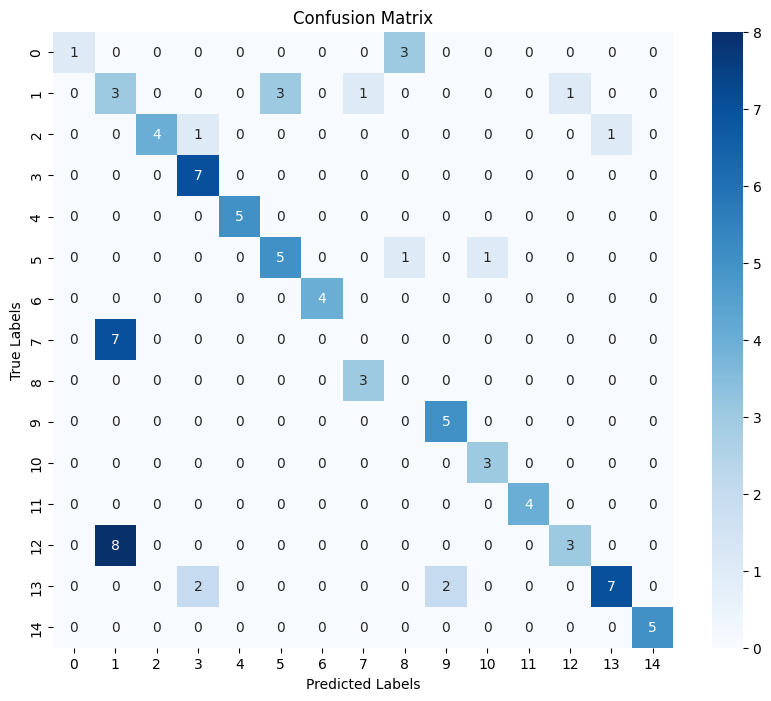

Accuracy: 0.6222222222222222
Precision: 0.6922751322751323
Recall: 0.6222222222222222
F1 Score: 0.6213431643462604
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       0.17      0.38      0.23         8
           2       1.00      0.67      0.80         6
           3       0.70      1.00      0.82         7
           4       1.00      1.00      1.00         5
           5       0.62      0.71      0.67         7
           6       1.00      1.00      1.00         4
           7       0.00      0.00      0.00         7
           8       0.00      0.00      0.00         3
           9       0.71      1.00      0.83         5
          10       0.75      1.00      0.86         3
          11       1.00      1.00      1.00         4
          12       0.75      0.27      0.40        11
          13       0.88      0.64      0.74        11
          14       1.00      1.00      1.00         5

    accuracy       

In [55]:
model = tf.keras.models.load_model('lstmmodel.keras')
y_hat = model.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_hat = np.argmax(y_hat, axis=1).tolist()
multilabel_confusion_matrix(y_true, y_hat)

conf_mat = confusion_matrix(y_true, y_hat)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

accuracy = accuracy_score(y_true, y_hat)
precision = precision_score(y_true, y_hat, average='weighted')
recall = recall_score(y_true, y_hat, average='weighted')
f1 = f1_score(y_true, y_hat, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

from sklearn.metrics import classification_report
class_report = classification_report(y_true, y_hat)
print(class_report)

References <br/>
MediaPipe - https://developers.google.com/mediapipe/solutions/vision/pose_landmarker/
https://www.geeksforgeeks.org/python-facial-and-hand-recognition-using-mediapipe-holistic/ <br/>
ASL Translation Model - https://medium.com/@er_95882/asl-recognition-using-pointnet-and-mediapipe-f2efda78d089